# 火山科学島原実習
３点の地震計アレイ観測により，地震波（常時微動）の到来方向とみかけ速度を推定する．

Google Colaboratoryを利用する場合は，最初に以下のセルを実行し，obspyをインストールする．ランタイムがリセットされたら，再び実行する必要がある．

In [ ]:
# Colaboratoryで最初に起動したときに実行
!pip install obspy

### 必要なパッケージを読み込む
readwin.py と lonlat2xy は同じフォルダーに入れておく．

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from obspy import Stream, UTCDateTime
from IPython.display import clear_output
import readwin, lonlat2xy
from scipy import signal

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['pdf.fonttype'] = 42

### パラメータの設定

In [49]:
# データ（winファイル）が存在するフォルダー
# 地震計1,2,3に対してそれぞれ指定
datadir1 = './data/edrx7000/08264/'
datadir2 = './data/edrx7000/08446/'
datadir3 = './data/edrx7000/08785/'


# 使用する時間範囲
# 全ての観測点でデータが存在している時間を指定
date1 = UTCDateTime('2023-07-16T15:50:00')
date2 = UTCDateTime('2023-07-16T15:58:00')

# バンドパスフィルターの周波数
f1 = 0.5
f2 = 1

# 観測点1,2,3の経度（longitude）と緯度（latitude）
lon1 = 130.360393
lat1 = 32.773520
lon2 = 130.360351
lat2 = 32.773190
lon3 = 130.360051
lat3 = 32.773416

# 平面（xy）に投影する際の原点座標（どれか一つの観測点でも，アレイ付近の任意の座標でもOK）
lon_ref = 130.360220
lat_ref = 32.773251


### フィルターの定義とデータの読み込み

In [50]:
def filter(f1, f2, st):
    st.detrend(type='constant')
    st.taper(type='cosine', max_percentage=0.04)
    st.filter('bandpass', freqmin=f1, freqmax=f2, zerophase=True)

In [56]:
# 地震計1,2,3のデータをそれぞれ読み込む．
# 上で指定したフォルダ内の全てのwinファイルを読み込む．
# ObsPyのStreamオブジェクトとして読み込まれる．
st1 = readwin.read_win(datadir1 + '*')
st2 = readwin.read_win(datadir2 + '*')
st3 = readwin.read_win(datadir3 + '*')
#print(st1)
#print(st2)
#print(st2[0].stats.starttime)
print(st1)
print(st2)
print(st3)

# 使用する範囲のデータを切り出す
# 短すぎないほうがいい
st1.trim(date1, date2)
st2.trim(date1, date2)
st3.trim(date1, date2)

# バンドパスフィルターを適用する
filter(f1, f2, st1)
filter(f1, f2, st2)
filter(f1, f2, st3)

# Streamオブジェクトからデータ（ndarray）を取り出す
# 取り出したいチャンネル番号を指定
wave1 = st1.select(channel='f000')[0].data
wave2 = st2.select(channel='f000')[0].data
wave3 = st3.select(channel='f000')[0].data

# Streamオブジェクトの中から情報を取り出す
stats = st1.select(channel='f000')[0].stats
dt = stats.delta    # サンプリング間隔
npts = stats.npts   # サンプル数（データの個数）
t = np.arange(stats.npts)*stats.delta   # 時間軸の作成


3 Trace(s) in Stream:
...f000 | 2023-07-16T15:15:33.000000Z - 2023-07-16T15:59:13.996000Z | 250.0 Hz, 655250 samples
...f001 | 2023-07-16T15:15:33.000000Z - 2023-07-16T15:59:13.996000Z | 250.0 Hz, 655250 samples
...f002 | 2023-07-16T15:15:33.000000Z - 2023-07-16T15:59:13.996000Z | 250.0 Hz, 655250 samples
3 Trace(s) in Stream:
...f000 | 2023-07-16T15:41:00.000000Z - 2023-07-16T15:58:27.996000Z | 250.0 Hz, 262000 samples
...f001 | 2023-07-16T15:41:00.000000Z - 2023-07-16T15:58:27.996000Z | 250.0 Hz, 262000 samples
...f002 | 2023-07-16T15:41:00.000000Z - 2023-07-16T15:58:27.996000Z | 250.0 Hz, 262000 samples
3 Trace(s) in Stream:
...f000 | 2023-07-16T15:27:37.000000Z - 2023-07-16T16:02:33.996000Z | 250.0 Hz, 524250 samples
...f001 | 2023-07-16T15:27:37.000000Z - 2023-07-16T16:02:33.996000Z | 250.0 Hz, 524250 samples
...f002 | 2023-07-16T15:27:37.000000Z - 2023-07-16T16:02:33.996000Z | 250.0 Hz, 524250 samples


### データをプロットしてみる

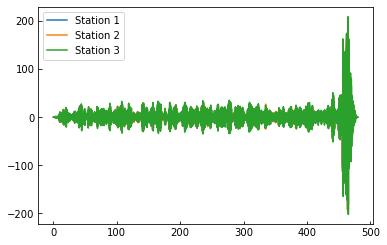

In [57]:
plt.plot(t, wave1, label='Station 1')
plt.plot(t, wave2, label='Station 2')
plt.plot(t, wave3, label='Station 3')
plt.legend()

### ノイズの中から全観測点に共通で似ている波を探す
読み込んだデータをある時間窓（window秒）ごと順番にプロットする．  
エンターを押すことで次の時刻（窓）へ進む．  
途中で止める時には esc を押す．

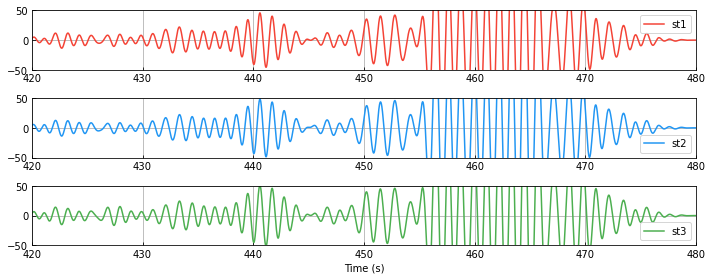

In [59]:
window = 60
n_window = int((date2 - date1)/window)
ymax = 50

for i in range(n_window):
    t1 = i*window
    t2 = t1 + window
    fig = plt.figure(figsize=(10,4),tight_layout=True)
    ax1 = fig.add_subplot(3,1,1)
    ax1.plot(t, wave1, color='#F44336', label='st1')
    ax1.set_xlim(t1, t2)
    ax1.set_ylim(-ymax, ymax)
    ax1.grid()
    ax1.legend()
    ax2 = fig.add_subplot(3,1,2)
    ax2.plot(t, wave2, color='#2196F3', label='st2')
    ax2.set_xlim(t1, t2)
    ax2.set_ylim(-ymax, ymax)
    ax2.grid()
    ax2.legend()
    ax3 = fig.add_subplot(3,1,3)
    ax3.plot(t, wave3, color='#4CAF50', label='st3')
    ax3.set_xlim(t1, t2)
    ax3.set_ylim(-ymax, ymax)
    ax3.grid()
    ax3.legend()
    ax3.set_xlabel('Time (s)')
    plt.show()
    input()
    clear_output(True)


### 波形の一部を切り出す
切り出す際には端の影響を軽減するために，コサインテーパー（tukey窓）をかけて両端を滑らかに落とす．

In [53]:
# 切り出す時間窓の設定
t1_cut = 400
t2_cut = 500
nt_cut = int((t2_cut-t1_cut)/dt)+1
t = np.arange(nt_cut)*dt + t1_cut

# コサインテーパー（tukey窓関数）
# 両端のそれぞれ0.5%の部分を滑らかに落とす
window = signal.tukey(nt_cut, alpha=0.1)

# コサインテーパーをかけてプロット
it1_cut = int(t1_cut/dt)
cut1 = wave1[it1_cut:it1_cut+nt_cut]*window
cut2 = wave2[it1_cut:it1_cut+nt_cut]*window
cut3 = wave3[it1_cut:it1_cut+nt_cut]*window
plt.plot(t, cut1, label='1')
plt.plot(t, cut2, label='2')
plt.plot(t, cut3, label='3')
plt.legend()

ValueError: operands could not be broadcast together with shapes (20001,) (25001,) 

### 相互相関関数を計算する
まずは2つの時系列の規格化した相互相関関数を計算する関数を定義

In [8]:
def cal_correlation(data1, data2, dt):
    ccf = np.correlate(data1, data2, mode='same')
    cc11 = np.correlate(data1, data1)   # np.sum(data1**2)と同じ
    cc22 = np.correlate(data2, data2)
    ccf /= np.sqrt(cc11*cc22)   # 規格化
    lag = np.arange(len(ccf))*dt - (len(ccf)//2)*dt
    return lag, ccf # ラグタイムの配列と相互相関関数を返す


観測点1,2,3の相互相関関数を計算する．  
定義より，例えば上の関数に観測点1，観測点2の順番で与えた場合，観測点1から2への経過時間（観測点2がどれだけ遅れているか）が，負のラグタイムにピークを持つ．

In [ ]:
# それぞれのペアの相互相関関数の計算
lag, cc12 = cal_correlation(cut1, cut2, dt)
_, cc23 = cal_correlation(cut2, cut3, dt)
_, cc31 = cal_correlation(cut3, cut1, dt)

# 相互相関関数が最大になるラグとその時の値を表示する
lag_12 = lag[np.argmax(cc12)]
lag_23 = lag[np.argmax(cc23)]
lag_31 = lag[np.argmax(cc31)]
print('station 1 - 2')
print('  peak:', cc12[np.argmax(cc12)])
print('  lag:', lag_12, '(s)')
print('')
print('station 2 - 3')
print('  peak:', cc23[np.argmax(cc23)])
print('  lag:', lag_23, '(s)')
print('')
print('station 3 - 1')
print('  peak:', cc31[np.argmax(cc31)])
print('  lag:', lag_31, '(s)')

# プロットする
fig = plt.figure(figsize=(5,5), tight_layout=True)
ax1 = fig.add_subplot(3,1,1)
ax1.plot(lag, cc12)
ax1.axvline(x=lag_12, color='red', linewidth=1)
ax1.set_title('CCF(1,2)')
ax1.set_xlim(-0.1,0.1)
ax1.set_ylim(0.5, 1)
ax1.grid()
ax2 = fig.add_subplot(3,1,2)
ax2.plot(lag, cc23)
ax2.axvline(x=lag_23, color='red', linewidth=1)
ax2.set_title('CCF(2,3)')
ax2.set_xlim(-0.1,0.1)
ax2.set_ylim(0.5, 1)
ax2.grid()
ax3 = fig.add_subplot(3,1,3)
ax3.plot(lag, cc31)
ax3.axvline(x=lag_31, color='red', linewidth=1)
ax3.set_title('CCF(3,1)')
ax3.set_xlim(-0.1,0.1)
ax3.set_ylim(0.5, 1)
ax3.set_xlabel('Lag Time (s)')
ax3.grid()

### 観測点の位置をプロットする
x軸の正が東，y軸の正が北になるようにしている．  
緯度・経度から平面座標に変換する関数は lonlat2xy.py の中で定義している．

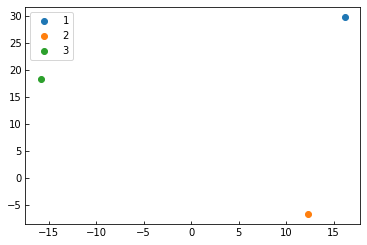

In [60]:
xy1 = lonlat2xy.lonlat2xy(lon1, lat1, lon_ref, lat_ref)
xy2 = lonlat2xy.lonlat2xy(lon2, lat2, lon_ref, lat_ref)
xy3 = lonlat2xy.lonlat2xy(lon3, lat3, lon_ref, lat_ref)
plt.scatter(xy1[0], xy1[1], label='1')
plt.scatter(xy2[0], xy2[1], label='2')
plt.scatter(xy3[0], xy3[1], label='3')
plt.legend()
plt.show()


### スローネスベクトルを求めてみよう
スローネスベクトルから波の伝播方向とみかけ速度を求めてみよう
$$
    \left[\begin{array}{c}
        t_3 - t_1 \\
        t_2 - t_1 \\
    \end{array}\right]
    = \left[\begin{array}{cc}
        x_3-x_1 & y_3-y_1 \\
        x_2-x_1 & y_2-y_1 \\
    \end{array}\right]\left[\begin{array}{c}
        s_x \\
        s_y \\
    \end{array}\right]
$$
を解いて，スローネス$\boldsymbol{s}$を求める．  
ラグタイムの符号に注意．

### 行列計算
たとえば
$$
    \begin{split}
    \left[\begin{array}{c}
        3 \\
        2 \\
    \end{array}\right]
    &= \left[\begin{array}{cc}
        1 & 5 \\
        2 & 3 \\
    \end{array}\right]\left[\begin{array}{c}
        x \\
        y \\
    \end{array}\right] \\
    A &= BX
    \end{split}
$$
を解く場合、


In [23]:
# 行列Aを定義
A = np.matrix([[3], [2]])
# 行列Bを定義
B = np.matrix([[1,5], [2, 3]])
# Bの逆行列
Bi = np.linalg.inv(B)

X = np.dot(Bi, A)

この例を参考に、スローネスの連立方程式を解く部分を書いてみよう！